In [4]:

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(1)


m = 20 # number of devices
n = 5  # number of servers

wD = np.random.randint(1 ,4 ,m )
wS = np.random.randint(1 ,4 ,n )

BD = np.random.uniform(50, 80, m)
BS = np.random.uniform(100, 300, n)
CD = np.random.uniform(100, 200, m)

class Trace(object):

    def __init__(self):
        data = np.loadtxt('trace_data/Lumos5G-v1.0/Lumos5G-v1.0.csv', delimiter=',', skiprows=1, usecols=(0,15)).astype(int)
        self.traces = []
        for run in np.unique(data[:,0]):
            trace = data[data[:,0]==run, 1]
            trace = 100/(trace + 1)
            self.traces.append(trace)
        self.trace_selection = np.random.choice(len(self.traces), (m,n))
        self.trace_counter = np.zeros_like(self.trace_selection)
        for i in range(m):
            for j in range(n):
                self.trace_counter[i,j] = np.random.choice(len(self.traces[self.trace_selection[i,j]]))

    def generate(self):
        rt = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                rt[i,j] = self.traces[self.trace_selection[i,j]][self.trace_counter[i,j]]
                self.trace_counter[i,j] += 1
                if self.trace_counter[i,j] == len(self.traces[self.trace_selection[i,j]]):
                    self.trace_counter[i,j] = 0
        return rt

# f(x, y, mu)
def f(x, y, mu, gamma=0):
    a = np.multiply(x[0, :], y)
    b = x[1:, :] @ y
    c = mu @ b
#     print('x0y:\t%.2f +- %.2f' %(np.average(a), np.std(a)))
#     print('xy:\t%.2f +- %.2f' %(np.average(b), np.std(b)))
#     print('uxy:\t%.2f +- %.2f' %(np.average(c), np.std(c)))
    return np.sum( 1 /np.sqrt(a + wD)) \
           + np.sum( 1 /np.sqrt(np.sqrt(b+ wS))) + gamma * np.sum(c)/m/n


# min f(x, y. mu)
def oracle(y, mu, gamma=0, hard=False):
    if hard:

        gamma = 0

    Y = cp.Parameter((m,), nonneg=True)
    Y.value = y

    x = cp.Variable((n + 1, m), nonneg=True)


    obj = cp.sum(cp.inv_pos(cp.sqrt(cp.multiply(x[0, :], y) + wD))) \
          + cp.sum(cp.inv_pos(cp.sqrt(x[1:, :] @ y + wS))) + gamma * cp.sum(mu @ (x[1:, :] @ y))/m/n

    constraints = [0 <= x, x <= 1,
                   cp.multiply(x[0, :], y) <= BD,
                   x[1:, :] @ y <= BS,
                   cp.sum(x, 0) == 1]

    if hard:
        constraints.append(mu @ (x[1:, :] @ y) <= CD)

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()  # Returns the optimal value.
    return x.value, prob.value, prob.status,


trace_gen = Trace()


/Users/yihu/opt/anaconda3/envs/Offloading-FL/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


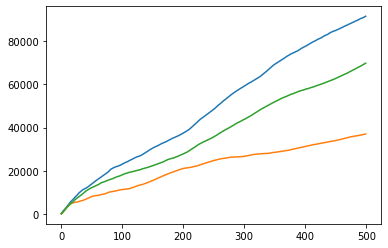

In [5]:
N = 3 # number of experiments
T = 500 # rounds per experiment
reg = np.zeros((N,T))
gamma = 1
for u in range(N):
    mu = trace_gen.generate()
    mu_hat = np.zeros_like(mu) # empirical mean
    T_ij = np.ones_like(mu) # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(80, 120, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu, gamma)

        rho_ij = np.sqrt(3*np.log(t+1)/(2*T_ij))
        mu_bar = np.max(mu_hat - rho_ij, 0) # LCB
        
        x_t, f_t, status = oracle(y, mu_bar, gamma)
        f_t = f(x_t, y, mu, gamma)
        
        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]        
        for i in range(m):
            j = np.random.choice(n+1, p=x_t[:,i])
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i,j])
                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt      
        
plt.plot(np.cumsum(reg,axis=1).T)
plt.show()

